# Hist Regressor Code Demo Training Script

Code to show how to train a Scikit learn model on an example dataset.

This code is not intended to be uploaded for BYOM but rather show how to create the necessary artefacts for running BYOM models.

The goal is to take a French 3rd party insurance auto dataset and to predict the Frequency of accidents, as a component of a Frequency+Severity (cost) model. This is a job undertaken by actuaries.

Typicaly actuaries use GLMs (generalised linear models), here we're using a cutting-edge tree based Gradient Boosting Model - a Random Forest on steroids, recently released. It can find non-linear relationships and interactions in the data and predict with a higher quality than an GLM.

The industry is moving this way and currently we do not have this in our Predict tool.

This code has largely been taken from: https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html


# TODO

* show resampling to find uncertainty in a fixed test set

In [1]:
from joblib import dump
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

print("Fetching dataset")
df = fetch_openml(data_id=41214, as_frame=True).frame

Fetching dataset


In [2]:
# ClaimNb is number of claims for the lifetime of the policy
# Exposure is the number of months for the life of this policy including holiday-cover (e.g. very low values representing days)
# Frequency is the expected frequency per month
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

* IDpol
* ClaimNb
* Exposure - amount of time in months that this coverage exists
* Frequency
* Area
* VehPower
* VehAge - younger vehicles may be more expensive to repair (but this might not affect a frequency model)
* DrivAge - younger drivers might have more accidents
* BonusMalue - "no claims" discount - you get a discount if you've had no accidents for multiple years (French naming)
* VehBrand - string code for vehicle type
* VehGas - Petrol or Diesel
* Density - ???

In [3]:
df.groupby('Area')['Density'].describe()

,count,mean,std,min,25%,50%,75%,max
Area,,,,,,,,
A,103957.0,27.502852,12.498298,1.0,16.0,27.0,38.0,50.0
B,75459.0,72.582184,14.844165,50.0,59.0,72.0,85.0,100.0
C,191880.0,248.935324,113.739091,100.0,150.0,222.0,335.0,500.0
D,151596.0,1075.898493,398.831083,500.0,725.0,1054.0,1328.0,1993.0
E,137167.0,4380.299598,1953.098541,2001.0,3184.0,3744.0,4762.0,9850.0
F,17954.0,22014.560878,6387.884636,10008.0,16052.0,27000.0,27000.0,27000.0


We can take a look at the whole dataframe. _What looks a bit odd here?_

* `DrivAge` and `VehAge` - what might the maximums mean? Should we do anything about it?

In [4]:
df.describe(include='all', percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency
count,6.780130e+05,678013.000000,678013.000000,678013,678013.000000,678013.000000,678013.000000,678013.000000,678013,678013,678013.000000,678013,678013.000000
unique,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,11,2,NaN,22,NaN
top,NaN,NaN,NaN,C,NaN,NaN,NaN,NaN,B12,Regular,NaN,R24,NaN
freq,NaN,NaN,NaN,191880,NaN,NaN,NaN,NaN,166024,345877,NaN,160601,NaN
mean,2.621857e+06,0.053247,0.528750,NaN,6.454631,7.044265,45.499122,59.761502,NaN,NaN,1792.422405,NaN,0.263964
std,1.641783e+06,0.240117,0.364442,NaN,2.050906,5.666232,14.137444,15.636658,NaN,NaN,3958.646564,NaN,4.593915
min,1.000000e+00,0.000000,0.002732,NaN,4.000000,0.000000,18.000000,50.000000,NaN,NaN,1.000000,NaN,0.000000
1%,1.993424e+04,0.000000,0.008219,NaN,4.000000,0.000000,20.000000,50.000000,NaN,NaN,10.000000,NaN,0.000000
5%,6.936560e+04,0.000000,0.040000,NaN,4.000000,0.000000,25.000000,50.000000,NaN,NaN,20.000000,NaN,0.000000
50%,2.272152e+06,0.000000,0.490000,NaN,6.000000,6.000000,44.000000,50.000000,NaN,NaN,393.000000,NaN,0.000000


In [5]:
print(f"Prior to removing beyond-one-year (erroneous?) exposures we had {df.shape[0]:,} rows")
df = df.query('Exposure <= 1')
print(f"After removing beyond-one-year (erroneous?) exposures we have {df.shape[0]:,} rows")

Prior to removing beyond-one-year (erroneous?) exposures we had 678,013 rows
After removing beyond-one-year (erroneous?) exposures we have 676,789 rows


In [6]:
df['VehGas'].value_counts()

Regular    345257
Diesel     331532
Name: VehGas, dtype: int64

## Observe that claim numbers rarely have large values - clip to something low

A policy might have many claims in a year but this is rare and hard to model using "simple" techniques, we avoid this complication by clipping the rare large values to a small but non-0 value.

In [7]:
accident_frequency_ser = df['ClaimNb'].value_counts(dropna=False).sort_index().reindex(range(17)).fillna(0)
accident_frequency_ser = accident_frequency_ser.astype(int).to_frame()
accident_frequency_ser

,ClaimNb
0,642780
1,32130
2,1781
3,82
4,7
5,2
6,1
7,0
8,1
9,1


In [8]:
df['ClaimNb'] = df['ClaimNb'].clip(0, 3)

In [9]:
accident_frequency_ser = df['ClaimNb'].value_counts(dropna=False).sort_index().reindex(range(5)).fillna(0)
accident_frequency_ser = accident_frequency_ser.astype(int).to_frame()
accident_frequency_ser

,ClaimNb
0,642780
1,32130
2,1781
3,98
4,0


## Review the data again

In [10]:
df.describe(include='all', percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency
count,6.767890e+05,676789.000000,676789.000000,676789,676789.000000,676789.000000,676789.000000,676789.000000,676789,676789,676789.000000,676789,676789.000000
unique,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,11,2,NaN,22,NaN
top,NaN,NaN,NaN,C,NaN,NaN,NaN,NaN,B12,Regular,NaN,R24,NaN
freq,NaN,NaN,NaN,191521,NaN,NaN,NaN,NaN,165959,345257,NaN,160529,NaN
mean,2.624026e+06,0.053172,0.527692,NaN,6.454065,7.042035,45.498650,59.766005,NaN,NaN,1791.924498,NaN,0.264370
std,1.642366e+06,0.237648,0.363857,NaN,2.050566,5.664687,14.140184,15.642270,NaN,NaN,3959.038575,NaN,4.598050
min,1.000000e+00,0.000000,0.002732,NaN,4.000000,0.000000,18.000000,50.000000,NaN,NaN,1.000000,NaN,0.000000
1%,1.990976e+04,0.000000,0.008219,NaN,4.000000,0.000000,20.000000,50.000000,NaN,NaN,10.000000,NaN,0.000000
5%,6.925980e+04,0.000000,0.040000,NaN,4.000000,0.000000,25.000000,50.000000,NaN,NaN,20.000000,NaN,0.000000
50%,2.272715e+06,0.000000,0.490000,NaN,6.000000,6.000000,44.000000,50.000000,NaN,NaN,393.000000,NaN,0.000000


# Make a transformer

We've only got a few columns here.

**Exercise** add more in to see what this does to the model. Does it take the model longer to build? Does the score improve?

**IAN TODO**

In [155]:
categorical_names = ["VehBrand", "VehPower", "VehGas", "Region", "Area"]
numeric_names = [ "Density"]
# STUDENTS - try using all of these numerics and contrast with just using Density in the line above
# Do you see an improvement in the Poisson Divergence score below with more features?
# How do the SHAP plots change?
#numeric_names = ["VehAge", "DrivAge", "BonusMalus", "Density"]

all_names = categorical_names + numeric_names
print(f"Processing all of {all_names}")

tree_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OrdinalEncoder(),
            categorical_names,
        ),
        ("numeric", "passthrough", numeric_names),
    ],
    remainder="drop",
)

inputs = tree_preprocessor.fit_transform(df)

Processing all of ['VehBrand', 'VehPower', 'VehGas', 'Region', 'Area', 'Density']


In [156]:
# split the original dataframe, the features (X) and the target (y) into
# a train and test set where the rows are the same in each train (or test) split
df_train, df_test, X_train, X_test, y_train, y_test = train_test_split(df, inputs, df['Frequency'], random_state=0)

In [157]:
df_train.shape, X_train.shape, y_train.shape

((507591, 13), (507591, 6), (507591,))

In [158]:
df_test.shape, X_test.shape, y_test.shape

((169198, 13), (169198, 6), (169198,))

In [159]:
# fiddling with parameters for a model can elicit gains, but they can be specific to the train/test split
# you're working on and so won't generalise to new (unseen) data
# Does fiddling with the tree leaf parameter MAX_LEAF_NODES (the fewest elements that can exist in a leaf
# before we declare that we can't split any further) improve the score by much?
MAX_LEAF_NODES = 256 # TRY 64
hist_model = HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=MAX_LEAF_NODES, random_state=0)
hist_model

HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=256,
                              random_state=0)

In [160]:
%%time
hist_model.fit(X_train, y_train, sample_weight=df_train['Exposure'])

CPU times: user 26.2 s, sys: 149 ms, total: 26.4 s
Wall time: 3.88 s


HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=256,
                              random_state=0)

In [174]:
# STUDENTS would we want to tune these? What benefit or cost might occur if we did?
hist_model.get_params() 

{'categorical_features': None,
 'early_stopping': 'auto',
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'poisson',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 100,
 'max_leaf_nodes': 256,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': 0,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

# Scoring

The R^2 score is the default, it isn't optimal for most problems but isn't a bad place to start. For our problem the Poisson Deviance is a better choice.

For R^2 we want a larger positive number, 0 means "no relationship", 1 means "perfect agreement" (which we can't have) and a negative number is worse that no relationship (i.e. really bad).

The Poisson Deviance takes account of our integer expected target, 0 is best and larger is worse.

In [162]:
y_pred = hist_model.predict(X_test)
y_pred[:5]

array([0.11488386, 0.094737  , 0.10229595, 0.07922292, 0.07657134])

In [163]:
%%time
hist_model.score(X_train, y_train, sample_weight=df_train['Exposure'])

CPU times: user 2.98 s, sys: 0 ns, total: 2.98 s
Wall time: 397 ms


0.008166459100625745

In [164]:
hist_model.score(X_test, y_test, sample_weight=df_test['Exposure'])

0.0015492083053235683

In [165]:
from sklearn.metrics import mean_poisson_deviance
# mean poisson variance - a measure of divergence from an expected Poisson (positive >= 0 integer) output
# 0 is best, larger positive values are worse
mean_poisson_deviance(y_test, y_pred, sample_weight=df_test['Exposure'])

0.6192569551565797

# SHAP explanations

In [166]:
import shap

In [167]:
explainer = shap.Explainer(hist_model, feature_names=all_names)
# take a subset of the first 100 rows, they've been randomly shuffled already
shap_values = explainer(X_test[:100])

In [168]:
shap.initjs()

## Feature importance

* Is the fuel type predictive? Might you expect it to be?
* Does accident frequency depend upon the geographic area where the policy is taken?
* Is vehicle age or driver age more predictive of accident frequency?

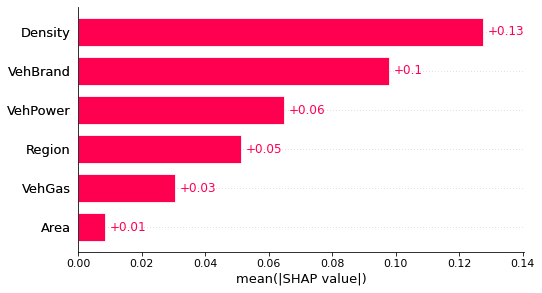

In [169]:
shap.plots.bar(shap_values)

## Force plots

A force plot explains a single prediction. Blue means "predict lower value" (i.e. fewer accidents), red means "make prediction larger" (i.e. expect more accidents). These contributions are added to come up with the final estimate (in this case a non-transformed number which is hard to explain, so ignore the bold item).

How do the following explanations feel? What story might you tell yourself? Can you imagine this being helpful when debugging?

In [170]:
shap.plots.force(shap_values[3])

In [171]:
shap.plots.force(shap_values[4])

In [172]:
shap.plots.force(shap_values[6])

## Swarm plots

Low values (blue) for BonusMalus mean that the SHAP impact is negative (left), so it brings down the expected frequency of accident. Red values (high) increase the SHAP impact, raising the estimate of accident frequency.

What does a red value mean for Vehicle Age? How does this impact predicted accident frequency?

What does a red value mean for Vehicle Power? How does this impact predicted accident frequency?

What does it means for the red and blue values to overlap for Area? We see something similar for Vehicle Gas (fuel) but more spread out - does that tell us more or less?

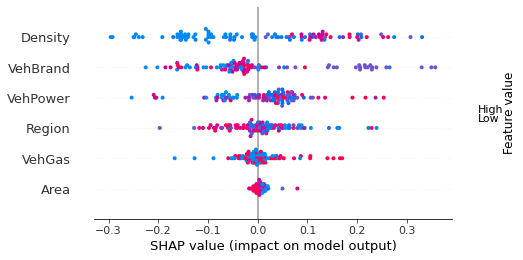

In [173]:
shap.plots.beeswarm(shap_values)